In [126]:
import numpy as np
from free_lie_algebra import *
import matplotlib.pyplot as plt

In [127]:
def chebyshev_T_polynomial(n):
    """Chebyshev polynomial of the first kind."""
    if n == 0:
        return {0: 1}
    elif n == 1:
        return {1: 1}
    else:
        T_prev = chebyshev_T_polynomial(n - 1)
        T_prev2 = chebyshev_T_polynomial(n - 2)
        T = {}

        for power, coeff in T_prev.items():
            T[power + 1] = T.get(power + 1, 0) + 2 * coeff

        for power, coeff in T_prev2.items():
            T[power] = T.get(power, 0) - coeff

        return T

def chebyshev_U_polynomial(n):
    """Chebyshev polynomial of the second kind."""
    if n == 0:
        return {0: 1}
    elif n == 1:
        return {1: 2}
    else:
        U_prev = chebyshev_U_polynomial(n - 1)
        U_prev2 = chebyshev_U_polynomial(n - 2)
        U = {}

        for power, coeff in U_prev.items():
            U[power + 1] = U.get(power + 1, 0) + 2 * coeff

        for power, coeff in U_prev2.items():
            U[power] = U.get(power, 0) - coeff

        return U

def expand_trig_n_theta(n, key='cos'):
    if key == 'cos':
        return chebyshev_T_polynomial(n)
    elif key == 'sin':
        expansion = chebyshev_U_polynomial(n-1)
        
        # Adjust for sin(theta) multiplier
        for power in list(expansion.keys()):
            expansion[power] = expansion.pop(power)
            
        return expansion
    else:
        raise ValueError("Invalid key. Use 'cos' or 'sin'.")

# Example
n = 1
expansion_cos = expand_trig_n_theta(n, key='cos')
expansion_sin = expand_trig_n_theta(n, key='sin')
print("Cosine expansion:", expansion_cos)
print("Sine expansion (multiplied by sin(theta)):", expansion_sin)

Cosine expansion: {1: 1}
Sine expansion (multiplied by sin(theta)): {0: 1}


In [128]:
# test
n = 25
expansion_cos = expand_trig_n_theta(n, key='cos')
expansion_sin = expand_trig_n_theta(n, key='sin')

t = np.linspace(-10, 10, 100)
e_cos = np.sum([value*np.cos(t)**key for key, value in expansion_cos.items()], axis=0)
e_sin = np.sum([value*np.sin(t)*np.cos(t)**key for key, value in expansion_sin.items()], axis=0)
print(np.linalg.norm(np.cos(n*t)-e_cos))
print(np.linalg.norm(np.sin(n*t)-e_sin))

1.8265440263573845e-07
2.641167090201369e-08


In [142]:
def fourier2sig(sig, N, t, P=1):
    recon = a_sig(sig, 0, 'cos', P)
    recon_cos = {n: a_sig(sig, n, 'cos', P) for n in range(1, N+1)}
    recon_sin = {n: a_sig(sig, n, 'sin', P) for n in range(1, N+1)}
    print(recon_cos)
    print(recon_sin)
    for n in range(1, N+1):
        recon += recon_cos[n]*np.cos(2*np.pi*n*t/P) + recon_sin[n]*np.sin(2*np.pi*n*t/P)
    return recon

def l(n, key, P=1):
    if n==0:
        return 1 / P * word2Elt('41')
    else:
        expansion = expand_trig_n_theta(n, key)
        l_n = 0*word2Elt('')
        for power, coeff in expansion.items():
            l_n += coeff*np.math.factorial(power)*word2Elt('2'*power)
        if key=='cos':
            print(n, key, 2 / P * rightHalfShuffleProduct(shuffleProduct(l_n, word2Elt('4')), word2Elt('1')))
            return 2 / P * rightHalfShuffleProduct(shuffleProduct(l_n, word2Elt('4')), word2Elt('1'))
        elif key=='sin':
            print(n, key, 2 / P * rightHalfShuffleProduct(shuffleProductMany([l_n, word2Elt('3'), word2Elt('4')]), word2Elt('1')))
            return 2 / P * rightHalfShuffleProduct(shuffleProductMany([l_n, word2Elt('3'), word2Elt('4')]), word2Elt('1'))

def a_sig(sig, n, key, P=1):
    return dotprod(l(n, key, P), sig)

def sig(t_grid, path, N):
    """Compute N+2 truncated signature of time-augmented weighted path."""
    P = t_grid[-1]-t_grid[0]
    path_aug_time = np.c_[t_grid, np.cos(2*np.pi*t_grid/P), np.sin(2*np.pi*t_grid/P), path]
    return signature_of_path_iisignature(path_aug_time, N+2)

In [143]:
def a(t_grid, path, N):
    P = t_grid[-1] - t_grid[0]
    a_arr = np.zeros(N+1)
    a_arr[0] = np.trapz(path, t_grid)/P
    for n in range(1, N+1):
        a_arr[n] = 2*np.trapz(path*np.cos(2*np.pi*n*t_grid/P), t_grid)/P
    return a_arr

def b(t_grid, path, N):
    P = t_grid[-1] - t_grid[0]
    b_arr = np.zeros(N+1)
    for n in range(1, N+1):
        b_arr[n] = 2*np.trapz(path*np.sin(2*np.pi*n*t_grid/P), t_grid)/P
    return b_arr

In [146]:
N = 1
t_grid = np.linspace(-1, 1, 100)
P = t_grid[-1] - t_grid[0]
path = np.cos(15*t_grid) - np.sin(3*t_grid) - (np.cos(-15) - np.sin(-3))
recon_path = fourier2sig(sig(t_grid, path, N), N, t_grid, P)
print(sig(t_grid, path, N))
print(a(t_grid, path, N), b(t_grid, path, N))

1 cos E[{}, {}, {}, {241: 1.0, 421: 1.0}]
1 sin E[{}, {}, {}, {341: 1.0, 431: 1.0}]
{1: 1.2332185616760998}
{1: -1.0189855293455923}
E[{: 1}, {1: 2.0, 2: -4.440892098500626e-16, 3: 2.3592239273284576e-16, 4: -0.2822400161197345}, {11: 2.0000000000000004, 12: -2.0000000000000004, 13: -3.391384395534658e-16, 14: -1.887656378204728, 21: 2.0000000000000004, 22: 1.9443450721809332e-15, 23: 3.1394840229999446, 24: -3.2013319347613187, 31: 4.945046108706386e-16, 32: -3.1394840229999432, 33: 3.196228004487267e-16, 34: 0.2826106887699574, 41: 1.3231763459652588, 42: 3.201331934761317, 43: -0.28261068876995743, 44: 0.039829713349633214}, {111: 1.3333333333333321, 112: -1.9999999999999991, 113: -0.6364060660396997, 114: -1.1965130069770897, 121: -2.434854175699814e-16, 122: 1.4996644460786475, 123: 3.1394840229999423, 124: -1.3228211474559168, 131: 1.272812132079399, 132: -3.1394840229999414, 133: 0.4996644460786479, 134: -0.3831023593442089, 141: -1.3822867424552752, 142: 3.120519741371484, 143:

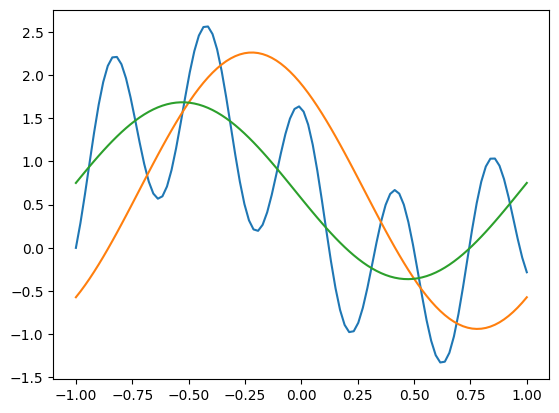

In [145]:
a_arr = a(t_grid, path, N)
b_arr = b(t_grid, path, N)
plt.plot(t_grid, path)
plt.plot(t_grid, recon_path)
plt.plot(t_grid, np.sum([a_arr[n]*np.cos(2*np.pi*n*t_grid/P)+
                         b_arr[n]*np.sin(2*np.pi*n*t_grid/P) for n in range(N+1)], axis=0))